O primeiro passo do nosso projeto foi decidir quais técnicas utilizar no nosso método clássico de classificação. Para representar o texto, optamos por uma combinação de Bag of Words (BoW) e TF-IDF. Essa combinação permite que o modelo aproveite tanto a frequência das palavras quanto sua importância.
Em seguida, escolhemos qual técnica de classificação usar. A decisão foi pela Regressão Logística, por ser um modelo simples, eficiente e ser capaz de lidar com classificação multi-label.

Começamos lendo os arquivos CSV de treino e teste, e em seguida separamos as colunas de texto e emoções. Além disso, criamos uma coluna adicional chamada "neutral", utilizada para marcar os casos em que nenhuma das emoções foi identificada.

In [1]:
import pandas as pd

data = pd.read_csv("treino/ptbr.csv")
teste = pd.read_csv("teste/ptbr.csv")


data["neutral"] = (data[["anger", "disgust", "fear", "joy", "sadness", "surprise"]].sum(axis=1) == 0).astype(int)
teste["neutral"] = (teste[["anger", "disgust", "fear", "joy", "sadness", "surprise"]].sum(axis=1) == 0).astype(int)

texto = data["text"]
emocao = data[["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]]

texto_teste = teste["text"]
emocao_teste = teste[["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]]



Para transformar os textos em vetores, utilizamos as ferramentas do scikit-learn, que permitem aplicar as técnicas de BoW e TFIDF, essas técinas são unidas em "junto". Após isso, criamos dois pipelines, um onde aplicamos a classificação considerando o balanceamento das classes da base de dados, atribuindo pesos maiores as classes minoritárias, e outro sem esse balanceameto, de modo que possamos fazer uma comparação para explicitar a importância do se balancear a base. Por fim, aplicamos um threshold customizado no pipeline balanceado para melhorar ainda mais o recall do modelo.

In [2]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

junto = FeatureUnion([
    ('count', CountVectorizer()),
    ('tfidf', TfidfVectorizer())
])

ordem = Pipeline([
    ('features', junto),
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight='balanced')))
])

ordem_sem_bal = Pipeline([
    ('features', junto),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])

ordem.fit(texto, emocao)
ordem_sem_bal.fit(texto,emocao)

probas = ordem.predict_proba(texto_teste)

threshold = 0.3141592653589793
predi = (probas >= threshold).astype(int)
predi_sem_bal = ordem_sem_bal.predict(texto_teste)


A seguir, geramos um relatorio com as metricas detectadas pela predição com e sem balanceamento.

In [3]:
from sklearn.metrics import classification_report

print(classification_report(emocao_teste, predi, target_names=emocao_teste.columns))
print(classification_report(emocao_teste, predi_sem_bal, target_names=emocao_teste.columns))



              precision    recall  f1-score   support

       anger       0.48      0.75      0.58       699
     disgust       0.18      0.24      0.21        71
        fear       0.20      0.24      0.22       139
         joy       0.47      0.72      0.57       555
     sadness       0.35      0.59      0.44       343
    surprise       0.13      0.24      0.17       157
     neutral       0.41      0.74      0.52       616

   micro avg       0.40      0.65      0.49      2580
   macro avg       0.32      0.50      0.39      2580
weighted avg       0.40      0.65      0.49      2580
 samples avg       0.44      0.67      0.50      2580

              precision    recall  f1-score   support

       anger       0.64      0.43      0.51       699
     disgust       0.00      0.00      0.00        71
        fear       0.60      0.04      0.08       139
         joy       0.76      0.41      0.53       555
     sadness       0.60      0.25      0.35       343
    surprise       0.20 

C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\theod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Como podemos observar, o balanceamento ajuda significativamente na detecção de classes minoritárias, que seriam completamente ignoradas pelo modelo sem balanceamento. Embora ocorra uma redução na precisão geral, o aumento expressivo no recall compensa essa perda, resultando em um F1-score maior em praticamente todas as classes. Dessa forma, obtém-se um modelo mais equilibrado e capaz de reconhecer de forma mais abrangente todas as emoções, inclusive aquelas menos frequentes.

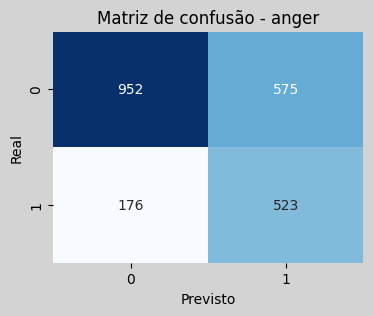

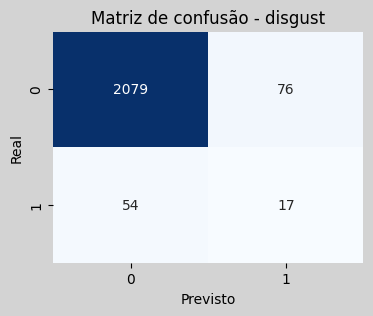

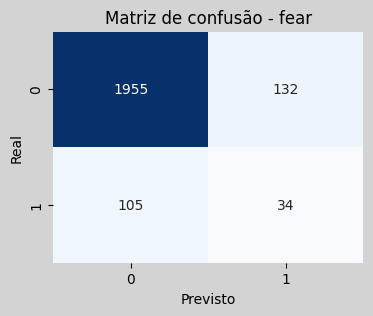

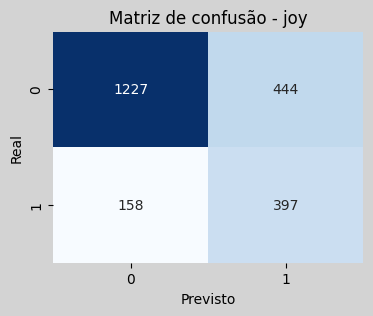

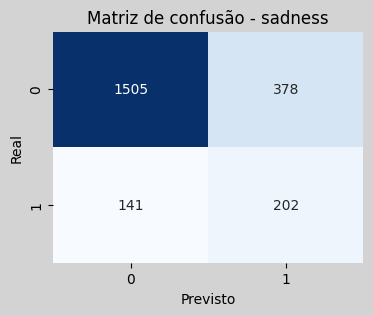

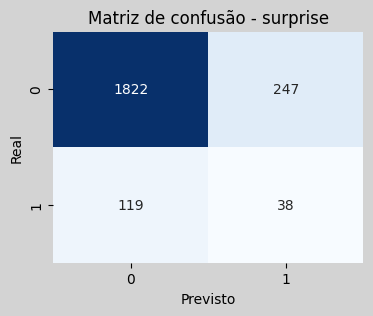

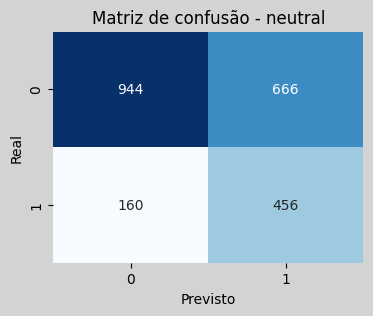

In [4]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for emocoes in emocao_teste.columns:
    verdadeiro = emocao_teste[emocoes].values
    predicao = predi[:, list(emocao_teste.columns).index(emocoes)]

    matriz = confusion_matrix(verdadeiro, predicao)

    plt.figure(figsize=(4, 3), facecolor='lightgray')
    sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Matriz de confusão - {emocoes}')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()

Acima, apresentamos as matrizes de confusão para todas as emoções que nosso modelo é capaz de classificar. Podemos notar que o modelo apresenta uma ótima capacidade para identificar corretamente quando uma frase não expressa determinada emoção. Entretanto, em algumas classes, o modelo ainda apresenta dificuldades para prever corretamente os casos positivos.